In [1]:
import pickle
import os
import numpy as np
import json
from PIL import Image,ImageDraw
import sys

import cv2
import matplotlib.pyplot as plt  
import matplotlib.patches as patches

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.measure import find_contours

from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import box
from random import sample
%matplotlib inline

In [118]:
# read detection results from pickle file
actualColors = {
    'Blues_4':[(239, 243, 255),(189, 215, 231),(107, 174, 214),(33, 113, 181)],
    'Blues_6':[(239, 243, 255),(198, 219, 239),(158, 202, 225),(107, 174, 214),(49, 130, 189),(8, 81, 156)],
    'Blues_8':[(247, 251, 255),(222, 235, 247),(198, 219, 239),(158, 202, 225),(107, 174, 214),(66, 146, 198),(33, 113, 181),(8, 69, 148)],
    'RdBu_4':[(202, 0, 32),(244, 165, 130),(146, 197, 222),(5, 113, 176)],
    'RdBu_6':[(178, 24, 43),(239, 138, 98),(253, 219, 199),(209, 229, 240),(103, 169, 207),(33, 102, 172)],
    'RdBu_8':[(178, 24, 43),(214, 96, 77),(244, 165, 130),(253, 219, 199),(209, 229, 240),(146, 197, 222),(67, 147, 195),(33, 102, 172)]
}
with open(r'C:\Users\jiali\Desktop\choroColorRead\colorRecognitionEvaluation' + '\\' + 'colorsOrderedImagesRemoveGrey3.pickle', 'rb') as f:
    colorsOrderedImages = pickle.load(f)

In [119]:
# ax = plt.gca()
# for i,actualColorKey in enumerate(actualColors.keys()):
#     actualColorsList = actualColors[actualColorKey]
#     actualColorsList.reverse()
#     if i < len(actualColors.keys()) / 2:
#         for j,actualColor in enumerate(actualColorsList):
#             patch = patches.Rectangle((j,30 - (i % 3) * 10),1,1, facecolor=tuple(ac / 255.0 for ac in actualColor), edgecolor='grey')
#             ax.add_patch(patch)
#     else:
#         for j,actualColor in enumerate(actualColorsList):
# #             print(j)
#             patch = patches.Rectangle((15 + j,30 - (i % 3) * 10),1,1, facecolor=tuple(ac / 255.0 for ac in actualColor), edgecolor='grey')
#             ax.add_patch(patch)
# ax.set_ylim([0, 31])
# ax.set_xlim([0, 31])
# ax.set_aspect(1)
# plt.show()

{'Blues_4': ['us_Blues_4_neg.jpg', 'us_Blues_4_neg1.jpg', 'us_Blues_4_nonAuto.jpg', 'us_Blues_4_nonAuto1.jpg', 'us_Blues_4_pos_large.jpg', 'us_Blues_4_pos_large1.jpg', 'us_Blues_4_pos_small.jpg', 'us_Blues_4_pos_small1.jpg'], 'Blues_6': ['us_Blues_6_neg.jpg', 'us_Blues_6_neg1.jpg', 'us_Blues_6_nonAuto.jpg', 'us_Blues_6_nonAuto1.jpg', 'us_Blues_6_pos_large.jpg', 'us_Blues_6_pos_large1.jpg', 'us_Blues_6_pos_small.jpg', 'us_Blues_6_pos_small1.jpg'], 'Blues_8': ['us_Blues_8_neg.jpg', 'us_Blues_8_neg1.jpg', 'us_Blues_8_nonAuto.jpg', 'us_Blues_8_nonAuto1.jpg', 'us_Blues_8_pos_large.jpg', 'us_Blues_8_pos_large1.jpg', 'us_Blues_8_pos_small.jpg', 'us_Blues_8_pos_small1.jpg'], 'RdBu_4': ['us_RdBu_4_neg.jpg', 'us_RdBu_4_neg1.jpg', 'us_RdBu_4_nonAuto.jpg', 'us_RdBu_4_nonAuto1.jpg', 'us_RdBu_4_pos_large.jpg', 'us_RdBu_4_pos_large1.jpg', 'us_RdBu_4_pos_small.jpg', 'us_RdBu_4_pos_small1.jpg'], 'RdBu_6': ['us_RdBu_6_neg.jpg', 'us_RdBu_6_neg1.jpg', 'us_RdBu_6_nonAuto.jpg', 'us_RdBu_6_nonAuto1.jpg', 'us

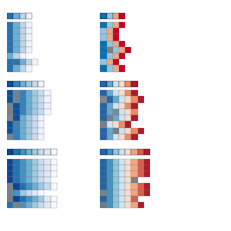

In [120]:
ax = plt.gca()
# actual colors
for i,actualColorKey in enumerate(actualColors.keys()):
    actualColorsList = actualColors[actualColorKey]
    actualColorsList.reverse()
    if i < len(actualColors.keys()) / 2:
        for j,actualColor in enumerate(actualColorsList):
            patch = patches.Rectangle((j,33 - (i % 3) * 11),1,1, facecolor=tuple(ac / 255.0 for ac in actualColor), edgecolor='black',linewidth = 0.25)
            ax.add_patch(patch)
    else:
        for j,actualColor in enumerate(actualColorsList):
#             print(j)
            patch = patches.Rectangle((15 + j,33 - (i % 3) * 11),1,1, facecolor=tuple(ac / 255.0 for ac in actualColor), edgecolor='black',linewidth = 0.25)
            ax.add_patch(patch)

# ordered colors
positionDict = {'Blues_4':[0,33],'Blues_6':[0,22],'Blues_8':[0,11],'RdBu_4':[15,33],'RdBu_6':[15,22],'RdBu_8':[15,11]}
saveColorsDict = {'Blues_4':[],'Blues_6':[],'Blues_8':[],'RdBu_4':[],'RdBu_6':[],'RdBu_8':[]}
for i,imageName in enumerate(colorsOrderedImages.keys()):
    baseMap = imageName.split('_')[0]
    if baseMap == 'ohio':
        continue
    orderedColorList = colorsOrderedImages[imageName]
    colorScheme = imageName.split('_')[1]
    numColors = imageName.split('_')[2]
    actualColorKey = colorScheme + '_' + numColors
#     print(actualColorKey)
    position = positionDict[actualColorKey]
#     print(position)
    saveColorList = saveColorsDict[actualColorKey]
    index = len(saveColorList) + 1
    for j,orderedColor in enumerate(orderedColorList):
#         if j == 1:
#             break
            
        patch = patches.Rectangle((position[0] + j,position[1] - index-0.5),1,1, facecolor=tuple(ac / 255.0 for ac in orderedColor),\
                                  edgecolor='grey',linewidth = 0.25)
        ax.add_patch(patch)
    saveColorsDict[actualColorKey].append(imageName)

print(saveColorsDict)

ax.set_ylim([0, 35])
ax.set_xlim([0, 35])
ax.set_aspect(1)
plt.axis('off')
# plt.show()

imageName = 'orderedColorResults.jpg'
plt.savefig(imageName,dpi=300,bbox_inches='tight')

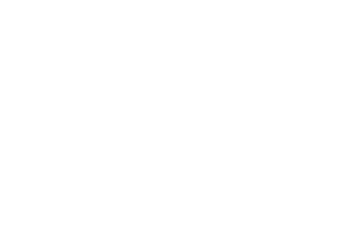

In [109]:
plt.axis('off')
plt.axis('equal')
# plt.show()ta


imageName = 'orderedColorResults.jpg'
plt.savefig(imageName,dpi=300,bbox_inches='tight')